In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json
import networkx as nx
import pulp

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

In [16]:
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice,DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig



Text(0.5, 1.0, 'Population of North Carl, N=1000')

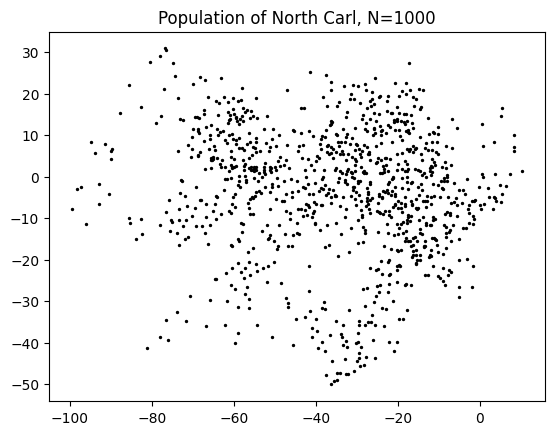

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [3]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost
    
R_antennas = 25

K-Means Lattice Generation

In [10]:
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_
antenna_pos = centers.copy()

Text(0.5, 1.0, 'Population of North Carl, N=1000')

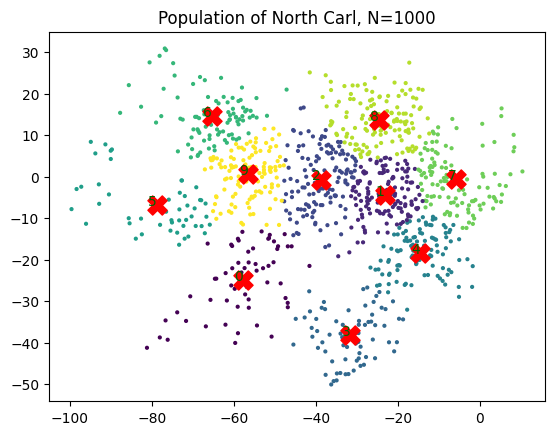

In [11]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))


Graph Generation

In [12]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

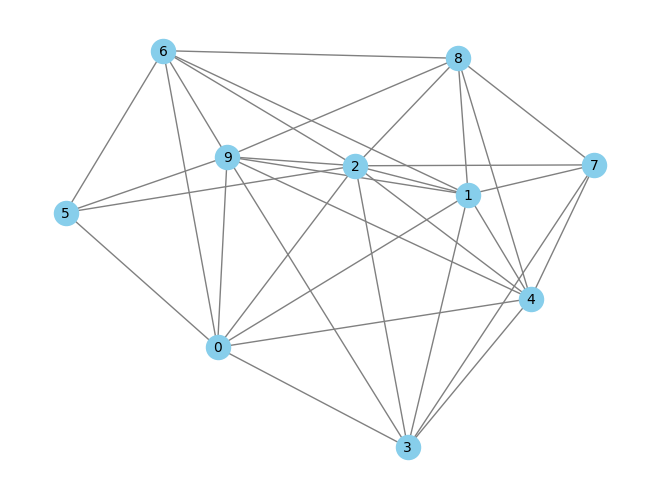

In [13]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

UDG embedding

In [27]:
coords = antenna_pos.copy()
val = np.min(pdist(coords))
coords *= 4/val

In [28]:
device_used = DigitalAnalogDevice
seed = 100

In [29]:
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
#print(Q)

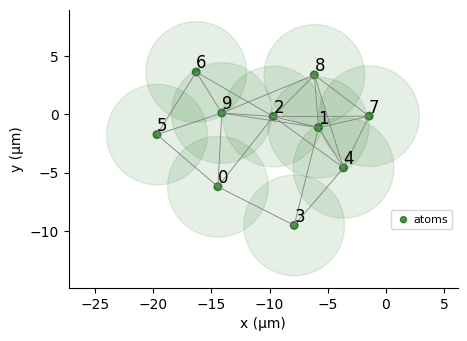

In [30]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
R =  np.median(Q[Q>0].flatten())
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(R),
    draw_graph = True,
    draw_half_radius = True, 
)

parameterised pulse

In [31]:
# Number of layers
layers = 2
omega = 2 * np.pi
detuning = 10

# Define sequence with two pulses
seq = Sequence(reg, device_used)
seq.declare_channel("ch0", "rydberg_global")

# Define variables for sequence of pulses
t_list = seq.declare_variable("t_list", size=layers) 
s_list = seq.declare_variable("s_list", size=layers)

for t, s in zip(t_list, s_list):
    pulse1 = Pulse.ConstantPulse(200 * t, omega, 0.0, 0) # omega - transverse field term
    pulse2 = Pulse.ConstantPulse(200 * s, 0.0, detuning, 0) # detuning - sigmaz term

    seq.add(pulse1, "ch0")
    seq.add(pulse2, "ch0")

seq.measure("ground-rydberg")

In [32]:
# Define a quantum loop that runs these sequences
def quantum_loop(params):
    params = np.array(params)
    t_params, s_params = np.reshape(params.astype(int), (2, layers))

    sample_sequence = seq.build(t_list=t_params, s_list=s_params)
    simulate = QutipEmulator.from_sequence(sample_sequence, sampling_rate=0.01) #
    results = simulate.run()

    count_dict = results.sample_final_state(N_samples = 100)
    return count_dict

QUBO formulation

In [34]:
adj_mtrx = nx.adjacency_matrix(G)
#adj_mtrx.todense()

diagonal_elements = -1*np.diag(z_coverage)*np.eye(adj_mtrx.shape[0])
#print('diagonal_elements',diagonal_elements)

alpha = 1000
offdiagonal_elements = alpha*adj_mtrx.todense()
#print('offdiagonal_elements', offdiagonal_elements)

qubo = diagonal_elements+offdiagonal_elements
print(qubo)

[[-177. 1000. 1000. 1000. 1000. 1000. 1000.    0.    0. 1000.]
 [1000. -558. 1000. 1000. 1000.    0. 1000. 1000. 1000. 1000.]
 [1000. 1000. -524. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
 [1000. 1000. 1000. -120. 1000.    0.    0. 1000.    0. 1000.]
 [1000. 1000. 1000. 1000. -365.    0.    0. 1000. 1000. 1000.]
 [1000.    0. 1000.    0.    0. -166. 1000.    0.    0. 1000.]
 [1000. 1000. 1000.    0.    0. 1000. -232.    0. 1000. 1000.]
 [   0. 1000. 1000. 1000. 1000.    0.    0. -388. 1000.    0.]
 [   0. 1000. 1000.    0. 1000.    0. 1000. 1000. -401. 1000.]
 [1000. 1000. 1000. 1000. 1000. 1000. 1000.    0. 1000. -380.]]


In [35]:
# Defining MWIS Cost Function
## Get cost based on Q matix
def get_cost_Q(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

## Get avergae cost
def get_avg_cost(counter, Q):
    cost = sum(counter[key] * get_cost_Q(key, Q) for key in counter)
    return cost / sum(counter.values())

QAOA algorithm on NAQC simulator

In [ ]:
# Main function that runs the pulses, obtains samples, and calcualtes the avg cost
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, Q)
    return cost

In [ ]:
scores = []
params = []

for repetition in range(10):
    guess = {
        "t": np.random.uniform(1, 10, layers),
        "s": np.random.uniform(1, 10, layers),
    }
    iteration = 0
    def callback(xk):
        global iteration
        global scores
        global params

        score = func(xk, qubo)
        scores.append(score)
        params.append(xk)
        print(f"Iteration {iteration}: x = {xk}")
        iteration += 1

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="COBYLA",
            tol=1e-5,
            options={"maxiter": 10},
            callback = callback,
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass